In [ ]:
#default_exp process_duplicates_image_level

# Process Duplicates Image-Level

> Process duplicate images by deleting them / doing other stuff to them.

In [ ]:
#hide 
from nbdev.showdoc import *

In [ ]:
#export
from fastcore.all import *
from cdiscount.find_duplicates import set_index_and_sort
import pandas as pd
from PIL import Image

## Overview

For **image-level** predictions, I will do the following:
- Labeled Test CSV: Create CSV mapping test img_name -> Prob. dist. of classes (proportional to appearances in train)
    - For test imgs duplicated in train
- To-Predict Test CSV: test img_name's for test images that don't appear in train
    - This should be disjoint with *Labeled Test CSV* and their union should be all test images
- Train CSV: map train img_name -> category_id (for train images that **don't** appear in test)
    - We won't train on images duplicated images (across train and test)

I will accomplish this by:
1. Get hashes of images duplicated across train and test
2. Map each image hash to probability vector of classes that image appears in in train
3. Create the 3 CSVs described above 

## Get Duplicated Images

### Load Hashes CSVs 

In [ ]:
path = Path("data"); path.ls()

(#17) [Path('data/multiple_categories.csv'),Path('data/sample_submission.csv'),Path('data/train.bson'),Path('data/train_hashes.csv'),Path('data/train_example.bson'),Path('data/cdiscount-image-classification-challenge.zip'),Path('data/TESTING'),Path('data/multiple_categories_and_in_train_and_test.csv'),Path('data/test.bson'),Path('data/test.csv')...]

In [ ]:
train_hashes_df,test_hashes_df = L("train_hashes.csv", "test_hashes.csv").map(
                                lambda f: pd.read_csv(path/f, index_col="image_hash", nrows=200))

In [ ]:
train_hashes_df.head()

,image_name,_id,category_id,in_test
image_hash,,,,
561546898ee257162bd3546a608cf06b,0_0.jpg,0,1000010653,False
f2d22c8f2a3fad9a113cebd44567a373,1_0.jpg,1,1000010653,False
00aab563ab16e5b2b043620792ac4420,2_0.jpg,2,1000004079,False
fff73c45a2c969fe94a51a0f9fd7e3e5,3_0.jpg,3,1000004141,False
da03c6e138c4c3a8010c29f168e50c8f,4_0.jpg,4,1000015539,False


In [ ]:
test_hashes_df.head()

,image_name,_id,category_id,in_test
image_hash,,,,
683cfc51a543e74063102c089db488fd,10_0.jpg,10,-1,True
649b6c8975d696753fae0a423c221446,10_1.jpg,10,-1,True
853c295f8d8a2f3ef30e9352789c5bf3,10_2.jpg,10,-1,True
ccc1d663f1a37024a0c0d14be8c2cf09,14_0.jpg,14,-1,True
1837dd959f79eab9725abeb3b3dc4eee,21_0.jpg,21,-1,True


In [ ]:
len(train_hashes_df), len(test_hashes_df)

(200, 200)

### Get Duplicates 

In [ ]:
def get_duplicated_hashes(train_hashes_df, test_hashes_df): 
    return set(train_hashes_df.index) & set(test_hashes_df.index)

In [ ]:
duplicated_hashes = get_duplicated_hashes(train_hashes_df, test_hashes_df); duplicated_hashes

{'00aab563ab16e5b2b043620792ac4420',
 '42276d516fe5405c08d940b616ab54eb',
 '4d2dafd4ae548a037c9ee502337babbe',
 '94cc07f4b99af3a12e38be72bcacfa03'}

## Map Image Hash to Probability Vector

### Map Image Hash to List of Classes in Train

In [ ]:
h = '00aab563ab16e5b2b043620792ac4420'

In [ ]:
L(train_hashes_df.loc[h].category_id)

(#1) [1000004079]

In [ ]:
h = "42276d516fe5405c08d940b616ab54eb"

In [ ]:
L(train_hashes_df.loc[h].category_id.to_list())

(#2) [1000004079,1000004079]

In [ ]:
def get_hash2categories(train_hashes_df, duplicated_hashes):
    hash2categories = {}
    for hash_ in duplicated_hashes:
        category_ids = train_hashes_df.loc[hash_].category_id
        try: category_ids = category_ids.to_list()
        except AttributeError: category_ids = [category_ids]  # Only 1 category_id in category_ids
        hash2categories[hash_] = L(category_ids)
    return hash2categories

In [ ]:
hash2categories = get_hash2categories(train_hashes_df, duplicated_hashes); hash2categories

{'00aab563ab16e5b2b043620792ac4420': (#1) [1000004079],
 '94cc07f4b99af3a12e38be72bcacfa03': (#2) [1000004079,1000004079],
 '42276d516fe5405c08d940b616ab54eb': (#2) [1000004079,1000004079],
 '4d2dafd4ae548a037c9ee502337babbe': (#2) [1000004079,1000004079]}

In [ ]:
for hash_ in hash2categories:
    print(train_hashes_df.loc[hash_].image_name)

2_0.jpg
image_hash
94cc07f4b99af3a12e38be72bcacfa03     43_1.jpg
94cc07f4b99af3a12e38be72bcacfa03    114_1.jpg
Name: image_name, dtype: object
image_hash
42276d516fe5405c08d940b616ab54eb     43_2.jpg
42276d516fe5405c08d940b616ab54eb    114_2.jpg
Name: image_name, dtype: object
image_hash
4d2dafd4ae548a037c9ee502337babbe     43_0.jpg
4d2dafd4ae548a037c9ee502337babbe    114_0.jpg
Name: image_name, dtype: object


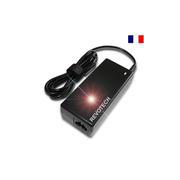

In [ ]:
Image.open(path/"images"/"43_0.jpg")

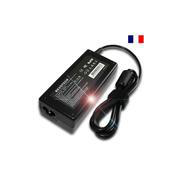

In [ ]:
Image.open(path/"images"/"43_1.jpg")

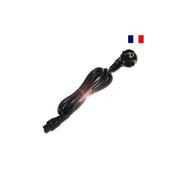

In [ ]:
Image.open(path/"images"/"43_2.jpg")

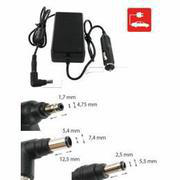

In [ ]:
Image.open(path/"images"/"2_0.jpg")

### Convert List of Classes to Probability Vector 

#### Create Vocab

First, we need to create a vocab, mapping `category_id` to `class_num`.

We'll make this vocab map the sorted `category_id`'s to their index in a list.

In [ ]:
category_df = pd.read_csv(path/"category_names.csv"); category_df[category_df.category_id == 1000004079]

,category_id,category_level1,category_level2,category_level3
2530,1000004079,INFORMATIQUE,CONNECTIQUE - ALIMENTATION,CHARGEUR - ADAPTATEUR SECTEUR - ALLUME CIGARE ...


In [ ]:
#export
def create_vocab(category_names_df):
    categories = L(category_names_df.category_id.unique().tolist())
    categories.sort()
    return categories.val2idx()

In [ ]:
vocab = create_vocab(category_df)
test_eq(vocab[1000000237], 0)
vocab

{1000000237: 0,
 1000000239: 1,
 1000000243: 2,
 1000000245: 3,
 1000000249: 4,
 1000000251: 5,
 1000000253: 6,
 1000000271: 7,
 1000000273: 8,
 1000000277: 9,
 1000000280: 10,
 1000000282: 11,
 1000000285: 12,
 1000000287: 13,
 1000000289: 14,
 1000000291: 15,
 1000000293: 16,
 1000000295: 17,
 1000000297: 18,
 1000000300: 19,
 1000000302: 20,
 1000000304: 21,
 1000000306: 22,
 1000000345: 23,
 1000000347: 24,
 1000000349: 25,
 1000000351: 26,
 1000000355: 27,
 1000000357: 28,
 1000000359: 29,
 1000000364: 30,
 1000000366: 31,
 1000000368: 32,
 1000000370: 33,
 1000000372: 34,
 1000000373: 35,
 1000000377: 36,
 1000000379: 37,
 1000000381: 38,
 1000000383: 39,
 1000000387: 40,
 1000000389: 41,
 1000000397: 42,
 1000000401: 43,
 1000000405: 44,
 1000000407: 45,
 1000000409: 46,
 1000000411: 47,
 1000000414: 48,
 1000000416: 49,
 1000000418: 50,
 1000000420: 51,
 1000000422: 52,
 1000000424: 53,
 1000000426: 54,
 1000000428: 55,
 1000000431: 56,
 1000000433: 57,
 1000000435: 58,
 100000

#### Use Vocab to Convert Classes List into Probability Vector 

In [ ]:
hash2categories

{'00aab563ab16e5b2b043620792ac4420': (#1) [1000004079],
 '94cc07f4b99af3a12e38be72bcacfa03': (#2) [1000004079,1000004079],
 '42276d516fe5405c08d940b616ab54eb': (#2) [1000004079,1000004079],
 '4d2dafd4ae548a037c9ee502337babbe': (#2) [1000004079,1000004079]}

In [ ]:
sm = hash2categories["42276d516fe5405c08d940b616ab54eb"].map(vocab.get); sm

(#2) [998,998]

In [ ]:
#export
def _category_list_to_probability_vector_helper(category_list, vocab):
    """Converts list of categories to probability vector."""
    probs = np.zeros(len(vocab))
    for category in category_list:
        probs[vocab[category]] += 1/len(category_list)
    return probs

In [ ]:
test_eq(category_list_to_probability_vector([1000000237, 1000000239], vocab), [0.5, 0.5] + [0.] * 5268)
test_eq(category_list_to_probability_vector([1000000237, 1000000237], vocab), [1.] + [0.] * 5269)

In [ ]:
#export
def convert_category_lists_to_probability_vectors(hash2categories: dict, vocab: dict):
    """Converts hash2categories category lists to probability vectors."""
    for hash_, category_list in hash2categories.items():
        hash2categories[hash_] = _category_list_to_probability_vector_helper(category_list, vocab)

In [ ]:
convert_category_lists_to_probability_vectors(hash2categories, vocab)

In [ ]:
one_hot_vector = np.zeros(len(vocab))
one_hot_vector[998] = 1.; one_hot_vector

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
# Test probabilty vectors are all correct
for hash_ in answer:
    assert np.all(one_hot_vector == hash2categories[hash_])

## Create CSVs

### Create *Labeled Test CSV*

To create *Labeled Test CSV*:
```
For each test image:
    Check if it appears in duplicated images mapping
        Map image name to probability vector
```

### Create *To-Predict CSV*

This is just test_imgs in test_hashes that are not in test_imgs_in_train_df.
Similar process for *Train CSV*: This is train_imgs not in train_imgs_in_test_df.

### Train CSV

This contains the train images that aren't in the test set.

## Script

In [ ]:
#export
@call_parse
def get_image_level_csvs(path: Param("Path to dir containing train_hashes.csv and test_hashes.csv", Path)="."):
    """Process duplicated images for image-level predictions.
    
    Saves the following CSVs in folder called "image_level_csv":
    - test_labeled.csv:      Test images duplicated in train, mapped to list of labels in train. 
    - test_to_predict.csv:   Test images not duplicated in train, to predict on.
    - train_non_duplicated.csv: Train images not duplicated in test, to train on.
    """
    train_hashes_df,test_hashes_df = L("train_hashes.csv", "test_hashes.csv").map(
                                lambda f: pd.read_csv(path/f, index_col=["image_hash", "image_name"]).sort_index())
    test_imgs_in_train_idxs = get_duplicated_image_idxs(test_hashes_df, train_hashes_df)
    train_imgs_in_test_idxs = get_duplicated_image_idxs(train_hashes_df, test_hashes_df)
    assert (set(_get_unique_hashes(test_hashes_df[test_imgs_in_train_idxs])) == 
            set(_get_unique_hashes(train_hashes_df[train_imgs_in_test_idxs])))
    
    # Create save dir
    save_path = path/"image_level_csvs"
    save_path.mkdir(exist_ok=True)
    
    print("Creating test_labeled.csv")
    test_labeled_df = get_test_imgs_to_train_categories(test_hashes_df[test_imgs_in_train_idxs], train_hashes_df)
    test_labeled_df.to_csv(save_path/"test_labeled.csv", index=False)
    print("Done")
    
    print("Creating test_to_predict.csv")
    test_to_predict_df = test_hashes_df.reset_index()[~test_imgs_in_train_idxs]["image_name"]
    test_to_predict_df.to_csv(save_path/"test_to_predict.csv", index=False)
    print("Done")
    
    # Check that test_labeled and test_to_predict are disjoint on image_name
    assert len(set(test_labeled_df.image_name) & set(test_to_predict_df)) == 0, "Overlap b/t test_labeled and test_to_predict"
    
    
    print("Creating train_non_duplicated.csv")
    train_non_duplicated_df = train_hashes_df.reset_index()[~train_imgs_in_test_idxs][["image_name", "category_id"]]
    train_non_duplicated_df.to_csv(save_path/"train_non_duplicated.csv", index=False)
    print("Done")
    
    print("Script completed.")
    return test_labeled_df, test_to_predict_df, train_non_duplicated_df

In [ ]:
#slow
%time test_labeled_df, test_to_predict_df, train_non_duplicated_df = get_image_level_csvs(path)

Creating test_labeled.csv


KeyboardInterrupt: 

In [ ]:
#hide
from nbdev.export import notebook2script; notebook2script()

Converted 00_process_bson.ipynb.
Converted 01_find_duplicates.ipynb.
Converted 02_process_duplicates_image_level.ipynb.
Converted 03_create_splits.ipynb.
Converted index.ipynb.
